<a href="https://colab.research.google.com/github/GwiHwan-Go/Reproduce_CutMix/blob/main/Training/CutMix_baseline_tinyImagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200

--2022-05-18 16:26:11--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 403 Forbidden
2022-05-18 16:26:11 ERROR 403: Forbidden.

replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace tiny-imagenet-200/wnids.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace tiny-imagenet-200/test/images/test_1860.JPEG? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
import json
import os
import torch


In [2]:

training_data_list = []
for folder in os.listdir('./tiny-imagenet-200/train/'):
  label = folder  # The name of the folder is the label of the images it contains
  for file in os.listdir('./tiny-imagenet-200/train/' + folder + '/images/'):
    file_dir = './tiny-imagenet-200/train/' + folder + '/images/' + file
    training_data_list.append((file_dir, label))
with open('./training_data_list.json', 'w') as f:
  json.dump(training_data_list, f)

testing_data_list = []
with open('./tiny-imagenet-200/val/val_annotations.txt', 'r') as f:
  for line in f.readlines():
    file, label = line.split()[0:2]
    file_dir = './tiny-imagenet-200/val/images/' + file
    testing_data_list.append((file_dir, label))

with open('./testing_data_list.json', 'w') as f:
  json.dump(testing_data_list, f)

In [3]:
with open('./tiny-imagenet-200/wnids.txt', 'r') as f :
  label_id = f.readlines()
label_id = [i[:-1] for i in label_id]
len(label_id)

200

In [4]:
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data.dataloader import *
import cv2 # OpenCV


In [5]:
class TinyImageDataset(Dataset):
  def __init__ (self, data, transform) :
    
    self.data = data
    self.transform = transform

  def __getitem__(self, index):
    img_path, label = self.data[index]
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
    if self.transform is not None:
      img = self.transform(img)
    return img, label_id.index(label)

  def __len__(self):
    return len(self.data)

In [6]:
file_name='./training_data_list.json'
with open(file_name, 'r') as f:
  data = json.load(f)

In [10]:
batch_size = 256
transform = transforms.Compose(
    [transforms.ToTensor()])

In [11]:
from sklearn.model_selection import train_test_split


train_dataset = TinyImageDataset(data = data, transform = transform)
train_set, valid_set = train_test_split(train_dataset, test_size=0.2)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

batch = next(iter(train_loader))
images, labels = batch


class labels: tensor([121, 189, 142, 121,   2, 195, 109,  73,  77, 143, 136,  60, 172,  45,
         39, 148, 196,   2,  58, 124,  19,  91, 167,  95, 144,  53,  33,  41,
        199, 101, 193, 175, 155,  18,  75, 138, 165,  68, 166, 113,  66,  56,
         19,  67,  91,  40, 112,  35, 165, 112,  12,  35, 199, 185,  64, 106,
         72, 149,  95, 117,  97,  23, 101,  64,  88, 122, 141,  32, 165,  38,
         39,   3,  90, 134, 128,  80,  58,  98,  18, 179,   7,  98, 159, 147,
        105,  40, 155, 174, 133, 119,  40,  20, 174, 181,   5,  60,  87, 112,
         73, 192,  12, 106, 117, 171, 179,  12, 133, 163,  65, 162,  19,  23,
        145, 155, 196,  92, 135, 131, 133, 112, 124, 172, 185,  17, 172,  44,
          3,   3,  65,  17, 128,  41, 111,  89,  11, 196,  27, 192,  38, 124,
        155,  36, 162, 186,  69,  29, 126,  19,  78,  69, 175,  42,  85,  63,
          7,  37, 198, 122,   7, 146, 110,  79, 153, 175,  64,  54, 131, 159,
        189, 145,  81, 139,  23,  22,  83, 102,  1

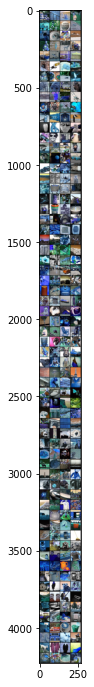

In [12]:
import matplotlib.pyplot as plt
import torchvision

plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

In [13]:
import numpy as np

def cut(W,H,lam):
        
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [14]:
images, labels = next(iter(train_loader))
rand_index = torch.randperm(images.shape[0])
shuffled_images = images[rand_index]
lam = np.random.beta(1.0, 1.0)
cutmix_images = images.clone().detach()
cutout_images = images.clone().detach() 
mixup_images = images.clone().detach() 

bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix

In [16]:
## CUTMIX ##
cutmix_images[:, :, bbx1:bbx2, bby1:bby2] = cutmix_images[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix

In [17]:
## CUTOUT ##
cutout_images[:, :, bbx1:bbx2, bby1:bby2] = 0.

In [18]:
## MIXUP ##
mixup_images = lam * mixup_images + (1 - lam) * mixup_images[rand_index,:,:]


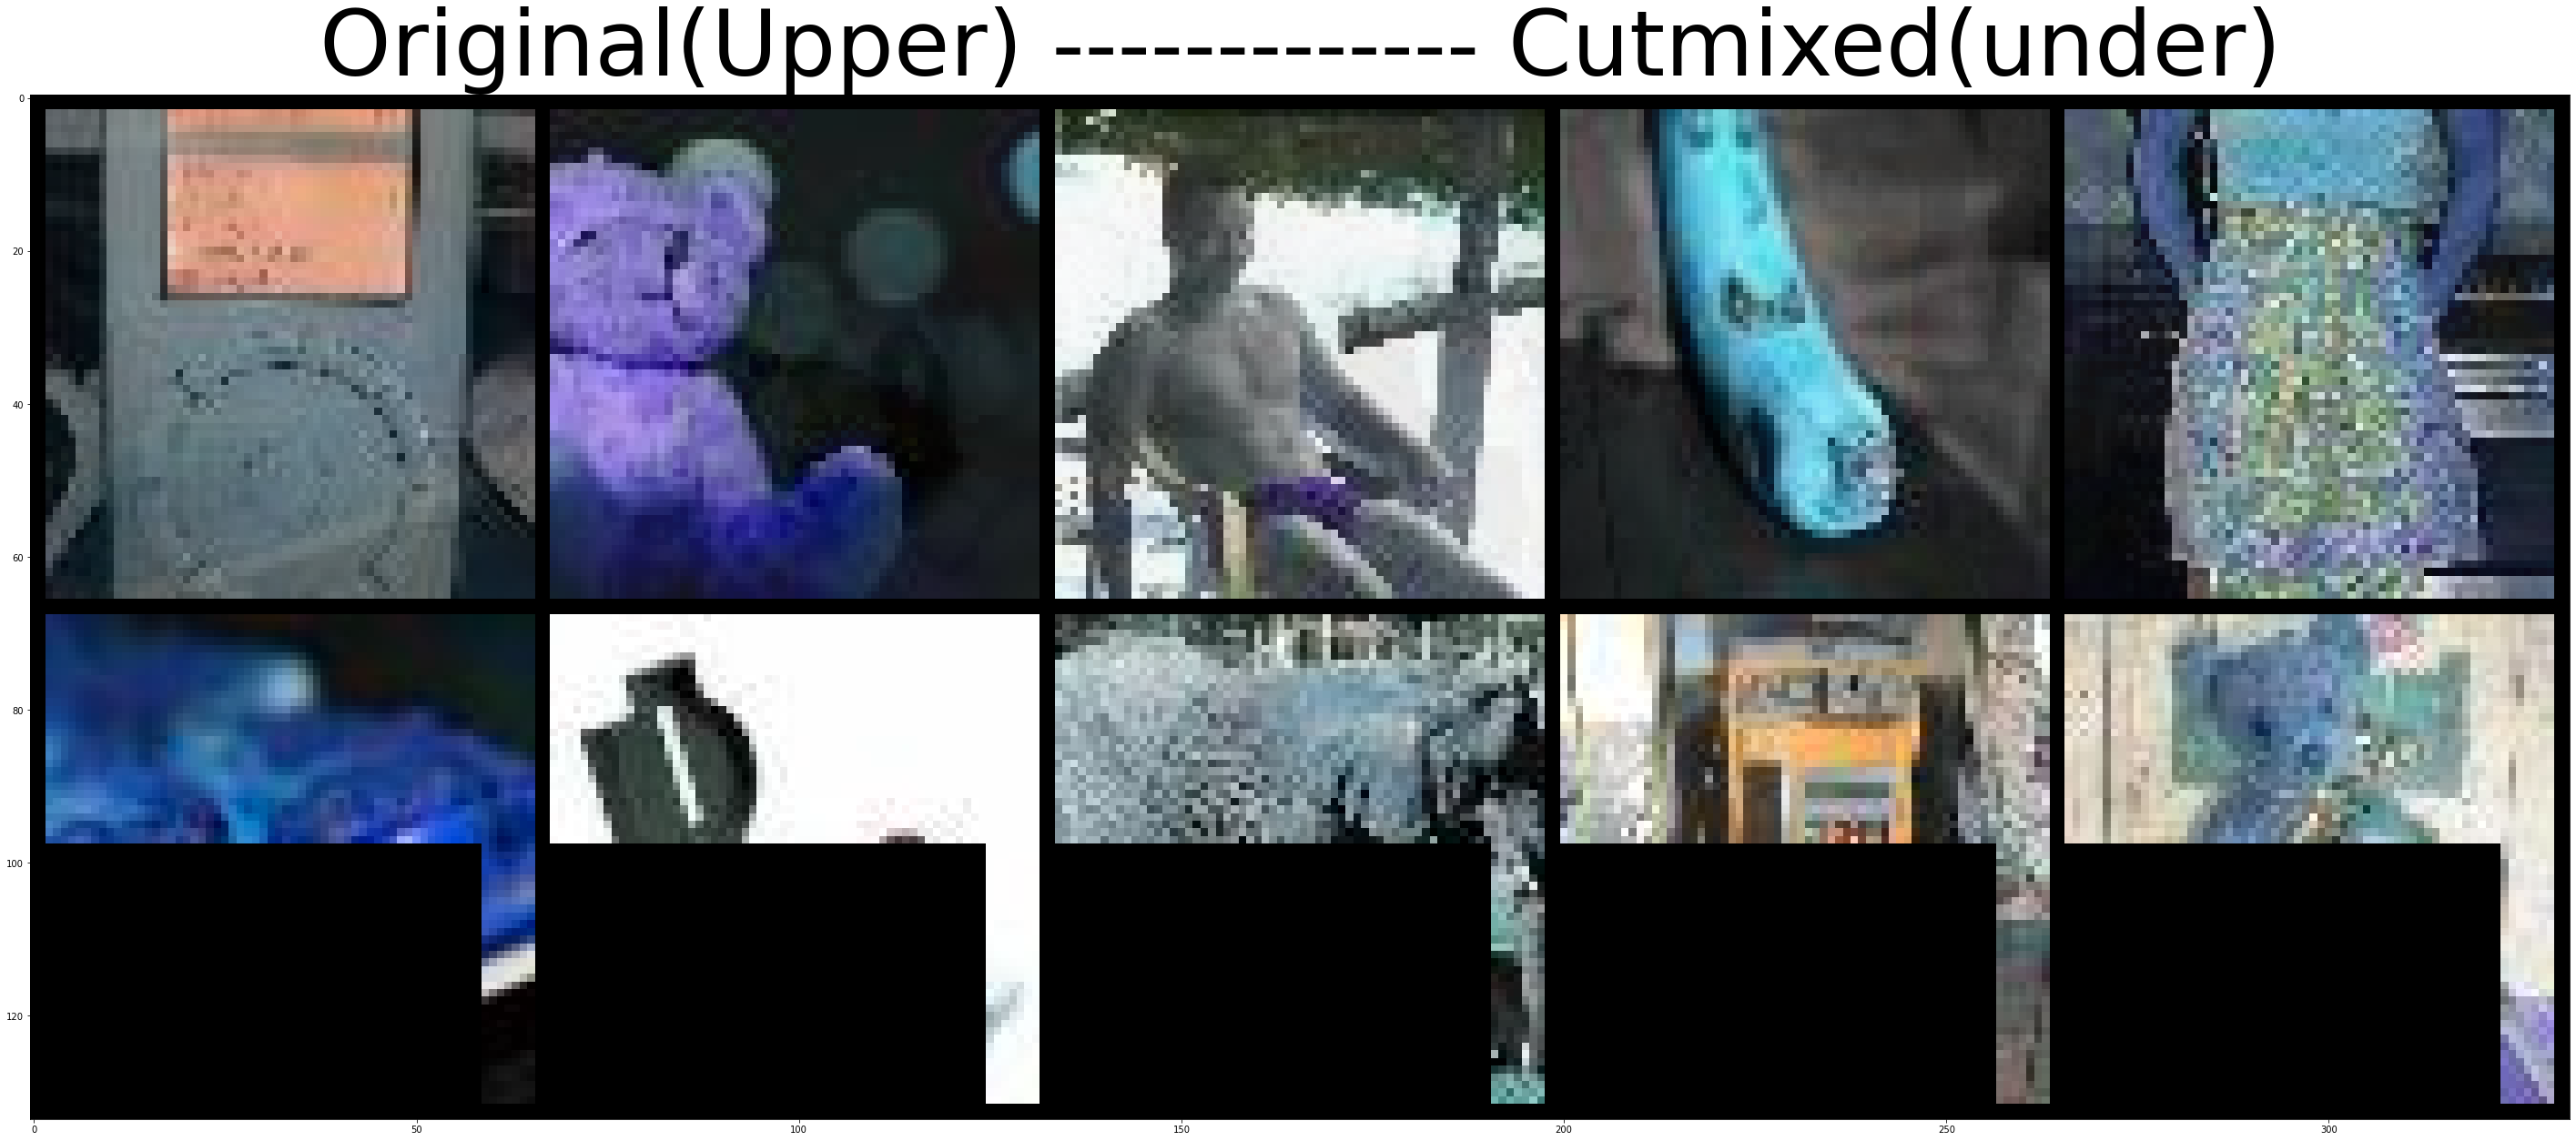

In [19]:
def show_cutMixed_compare(origin, new, nums_show):
    rand_index = torch.randperm(origin.size()[0])[:nums_show]
    to_compare = torch.cat([origin[rand_index,:,:],new[rand_index,:,:]],dim=0)
    plt.figure(figsize=(50,50))
    grid = torchvision.utils.make_grid(tensor=to_compare, nrow=nums_show)
    plt.title("Original(Upper) ------------- Cutmixed(under)", fontsize=100)
    plt.imshow(grid.permute(1,2,0))

show_cutMixed_compare(mixup_images, cutout_images, 5)

In [20]:
from torch.nn import Linear
from torchvision import models

# VGG16 Model Loading
use_pretrained = True
model = models.resnet50(pretrained=use_pretrained)
## 우리 이미지 사이즈에 맞게 튜닝

model.fc = torch.nn.Linear(2048, len(labels)) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

cpu


In [21]:
import torch.optim as optim
import torch.nn as nn
from tqdm.auto import tqdm, trange

def get_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval() # For later #
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return 100.0 * correct / total

def train_model(model, 
                train, 
                valid, 
                n_iters=500, 
                learn_rate=0.001, 
                batch_size=128, 
                weight_decay=0, 
                which_method=0):  # Lists to store model's performance information
  losses, train_acc, val_acc = [], [], []
  train_high, valid_high = 0, 0
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

  for i in trange(n_iters):
    for images, labels in tqdm(train) :
      images, labels = images.to(device), labels.to(device)
      model.train() # For Dropout and Batch Norm layers #

      if which_method and (np.random.rand()<0.5) :

        lam = np.random.beta(1.0, 1.0)
        rand_index = torch.randperm(images.size()[0])
        shuffled_labels = labels[rand_index]

        ##############Do Something On Data###############
        if which_method == 1 : ##cutmix
          bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
          images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix
          lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.shape[-1] * images.shape[-2]))
          show_cutMixed_compare(images, images, 5)
          break
        if which_method == 2 : ##mixup
          images = lam * images + (1 - lam) * images[rand_index,:,:]
        if which_method == 3 : ##cutout
          bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
          images[:, :, bbx1:bbx2, bby1:bby2] = 0.
        ##############Do Something On Data###############

        #############Forward Pass##############
        out = model(images) 
        #############Forward Pass##############

        ##############Modify Loss Function###############
        if which_method == 1 : ##cutmix
          loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam) # compute the total loss
        if which_method == 2 : ##mixup
          loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam)
        if which_method == 3 : ##cutout
          loss = criterion(out, labels)
        ##############Modify Loss Function###############

      else : ## if random.rand > 0.5 or which_method == 0
        
        out = model(images)
        loss = criterion(out, labels)

      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # reset the gradients for the next iteration

    train_score = get_accuracy(model, train_loader)
    valid_score = get_accuracy(model, valid_loader)

    # if valid_score > valid_high :
    #   valid_high = valid_score
    #   torch.save(model.state_dict(), './model.pth')

    train_acc.append(train_score)
    val_acc.append(valid_score)
    losses.append(float(loss)/batch_size) 




  print(f'Plotting')
  # Plotting Training Loss, Accuracy and Validation Accuracy
  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  plt.title("Training Curve")
  plt.plot(np.arange(n_iters), losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")

  plt.subplot(1,2,2)
  plt.title("Training Curve")
  plt.plot(np.arange(n_iters), train_acc, label="Train")
  plt.plot(np.arange(n_iters), val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()
  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-247252dc9e61>", line 3, in <module>
    weight_decay=0, which_method=1)
  File "<ipython-input-21-3e705382ce86>", line 77, in train_model
    train_score = get_accuracy(model, train_loader)
  File "<ipython-input-21-3e705382ce86>", line 11, in get_accuracy
    output = model(imgs)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torchvision/models/resnet.py", line 283, in forward
    return self._forward_impl(x)
  File "/usr/local/lib/python3.7/dist-packages/torchvision/models/resnet.py", line 273, in _forward_impl
    x = self.layer3(x)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1110, in _call

KeyboardInterrupt: ignored

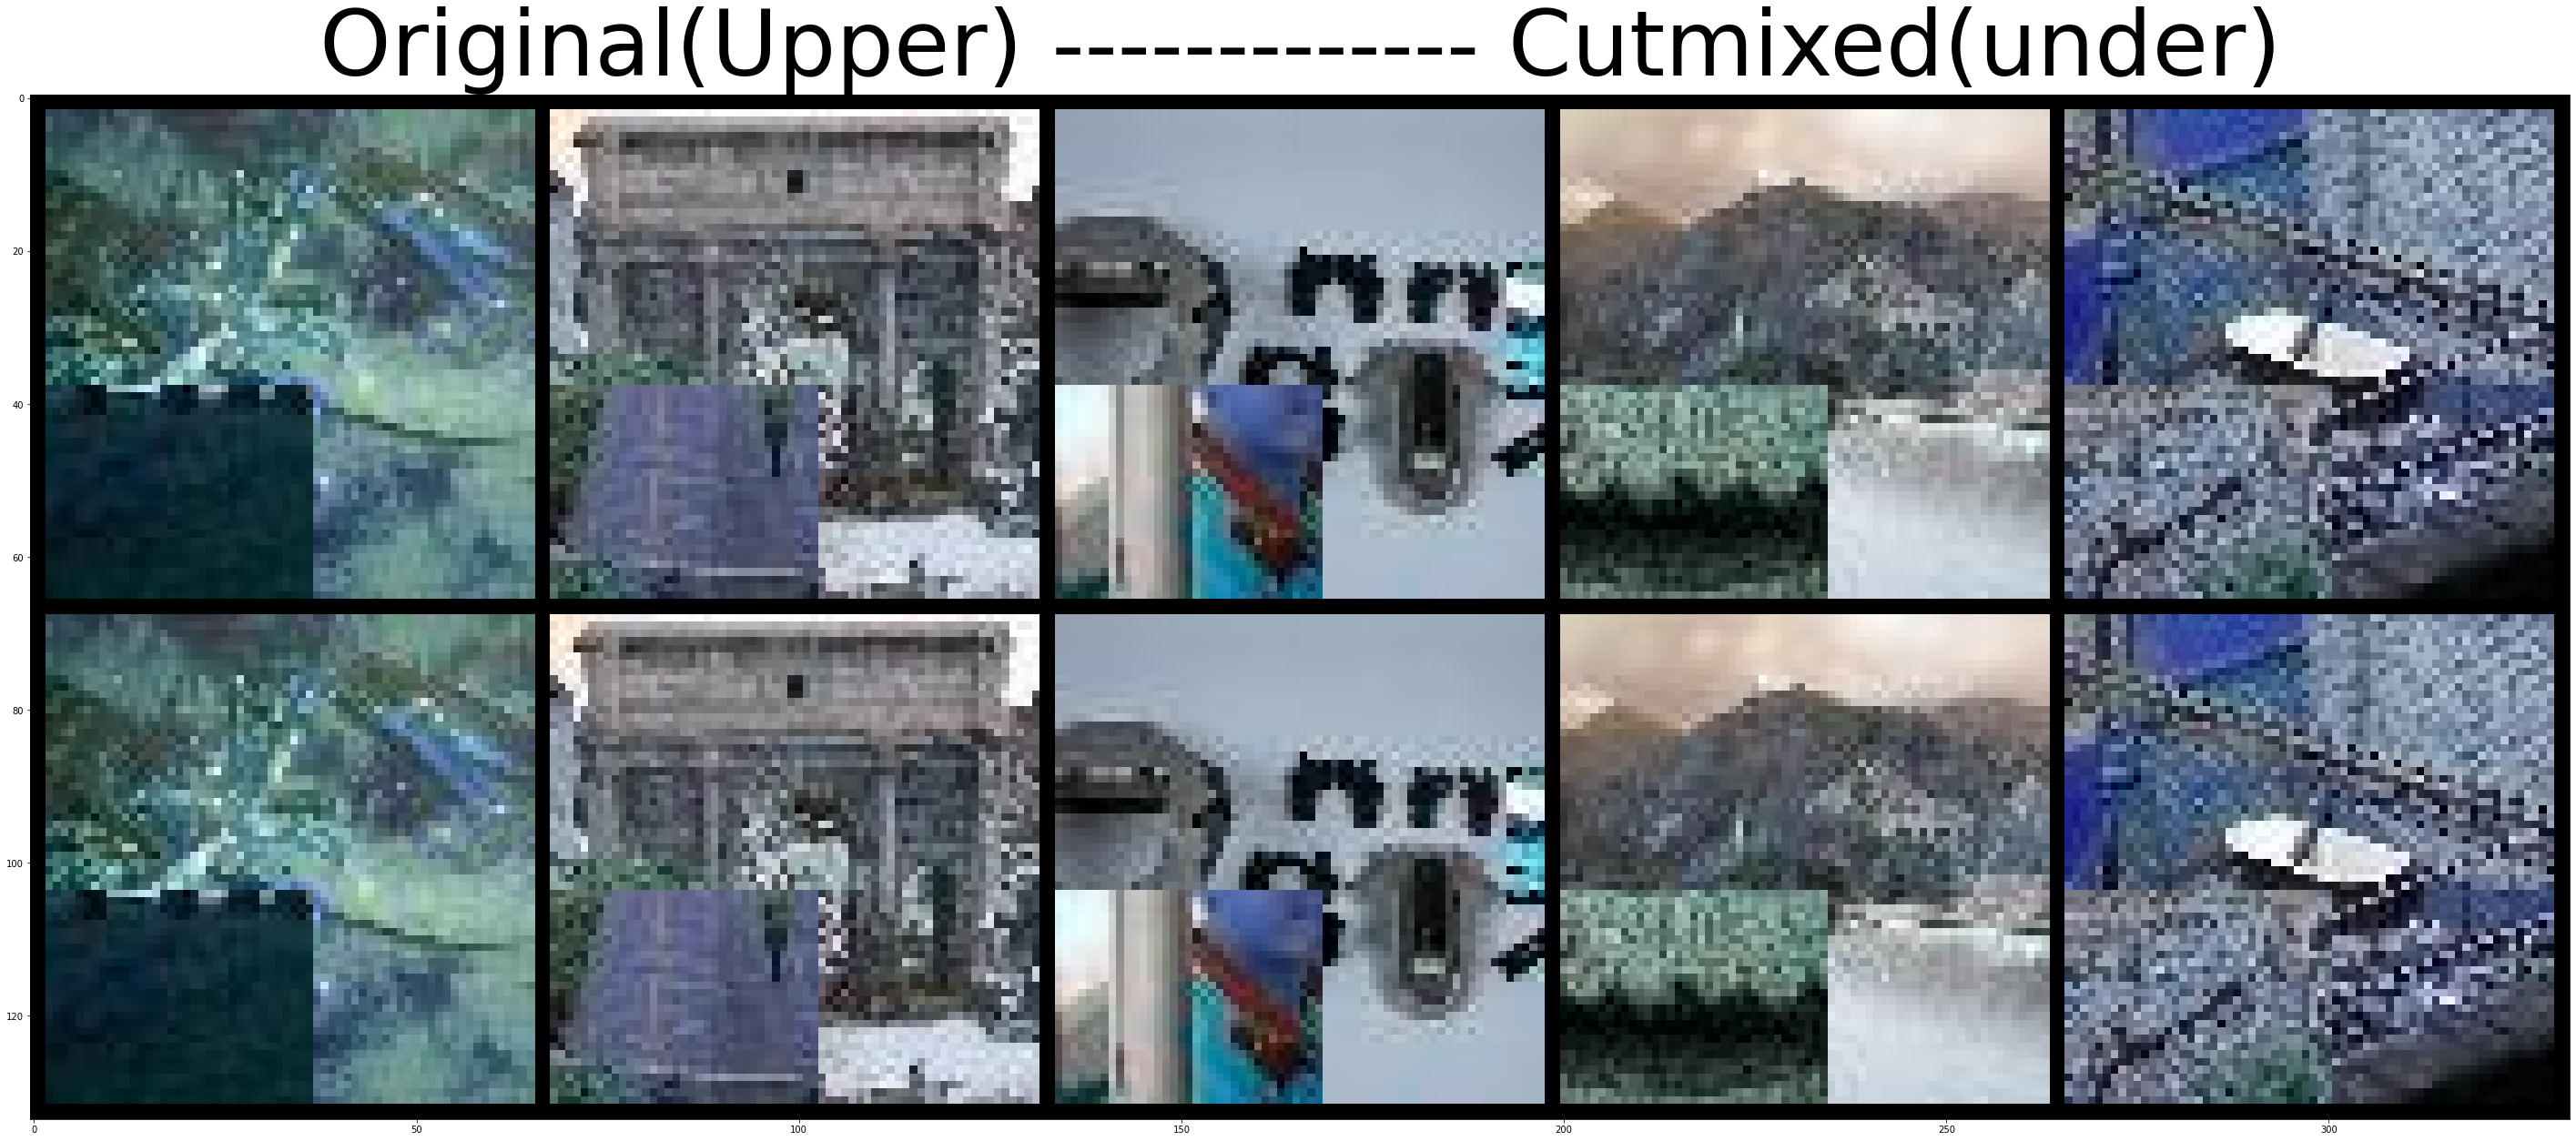

In [22]:
train_model(model, train_loader, valid_loader, n_iters=3, 
                learn_rate=0.001, batch_size=128, 
            weight_decay=0, which_method=1) 

#which method 0 : nothing, 1: cutmix, 2: mixup 3: cutout

https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py